In [1]:
import os

import numpy as np

import torch
from torch import nn

from torch.optim import Adam

from simulations import *
from vae import *
from training_vae import *
from outcome_models import *

from utilities import *
from visualisation import *

import itertools
import pandas as pd
import matplotlib.pyplot as plt

## 0. Data simulation

In [29]:
nb_obs = 1e3
seq_len = 50
order = 2   # ordre associe au modele arma
confounder_distribution = 'normal'
mu_noise, sigma_noise = 0, .01**2
theta = 0.5
sigma_confounder=2
poisson_par = 0.

nb_treatments = 2   # nombre traitements que l'on veut considerer dans l'etude

start = 4
batch_size = 256

In [30]:
A, Y, _, U = AR(int(nb_obs), 
                seq_len, 
                order=order, 
                mu_noise=mu_noise, 
                sigma_noise=sigma_noise, 
                theta_y=theta, 
                theta_a=theta, 
                confounder_distribution=confounder_distribution, 
                sigma_confounder=sigma_confounder, 
                poisson_par=poisson_par, 
                treatment_effect=False, 
                seed=0)

data = {'A':A[start:start + nb_treatments], 'Y':Y[start - order + 1 : start + nb_treatments+1], 'U':U}
A_train, A_valid, Y_train, Y_valid, U_train, U_valid = kfold(data, 2)

train = preprocessing(A_train, Y_train[:, :Y_train.shape[1]-1], U_train, batch_size)
valid = preprocessing(A_valid, Y_valid[:, :Y_valid.shape[1]-1], U_valid, batch_size)

A_test, Y_test, _, U_test = AR(int(nb_obs * .2), 
                seq_len, 
                order=order, 
                mu_noise=mu_noise, 
                sigma_noise=sigma_noise, 
                theta_y=theta, 
                theta_a=theta, 
                confounder_distribution=confounder_distribution, 
                sigma_confounder=sigma_confounder, 
                poisson_par=poisson_par, 
                treatment_effect=False, 
                seed=0)

A_test, Y_test, U_test = np.array(A_test).T, np.array(Y_test).T, np.array(U_test).T

A_test = A_test[:, start:start + nb_treatments]
Y_test = Y_test[:, start - order + 1 : start + nb_treatments+1]

## 1. VAE


### 1.0 Initialization 

In [4]:
lr = 1e-3
nb_epoch = 2000
kl_coef = .000
kl_begin, kl_end = 1000, 1500

cvae = CVAE(a_dim=nb_treatments, y_dim=nb_treatments+order-1, latent_dim=1, order=order, 
            kl_coef=kl_coef, kl_begin=kl_begin, kl_end=kl_end)
params = cvae.parameters()
optimizer = Adam(params, lr=lr)

### 1.1 Training

In [5]:
models, loss_train_stack, loss_valid_stack, recon_train_stack, recon_valid_stack, kl_train_stack, kl_valid_stack, err_train, err_valid = training(train, valid, cvae, optimizer, nb_epoch)

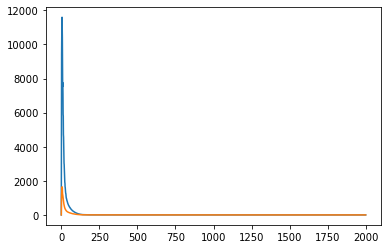

In [6]:
plt.plot(loss_train_stack)
plt.plot(loss_valid_stack)

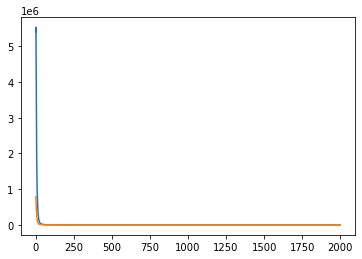

In [7]:
plt.plot(kl_train_stack)
plt.plot(kl_valid_stack)

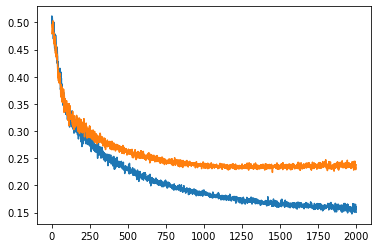

In [8]:
plt.plot(recon_train_stack)
plt.plot(recon_valid_stack)

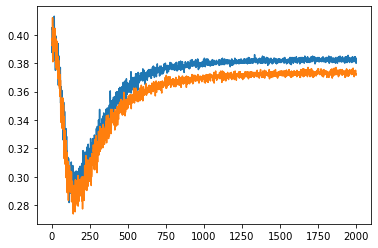

In [9]:
plt.plot(err_train)
plt.plot(err_valid)

### 1.2. Outcome models

Preparation des données

In [23]:
k = 200
model = models[k]

strategies = list(itertools.product([0, 1], repeat=nb_treatments))    

A = np.concatenate((A_train, A_valid))
Y = np.concatenate((Y_train, Y_valid))
U = np.concatenate((U_train, U_valid))

train_set = data_wrapup(A, Y, U, int(nb_obs), model)
test_set = data_wrapup(A_test, Y_test, U_test, int(nb_obs), model)

Calculs

In [24]:
confounder_types = ['oracle', 'random', 'proxy', 'none']

boxe = []

for variable in confounder_types:
    train = [train_set['outcomes'], train_set['treatments'], train_set[variable]]
    test = [test_set['outcomes'], test_set['treatments'], test_set[variable]]
    
    print(variable)
    
    R = stats(train=train, test=test, strategies=strategies)[0][0]
    
    boxe.append('{} : {}'.format(variable, np.round(R, 3)))
    
    print(variable, ":", R)

oracle
oracle : 0.2021277460120083
random
random : 0.20161727755024908
proxy
proxy : 0.21860891458304502
none
none : 0.21752625406454207


Moyenne mobile de l'environnement

In [12]:
# idx = nb_epoch - 1

# h_train, h_test = [], []

# window = 1

# window_min, window_max = max(0, idx-window), min(nb_epoch, idx+window)

# for k in range(0, nb_epoch, 1):
        
#     train_set = data_wrapup(A, Y, U, int(nb_obs), models[k])
#     test_set = data_wrapup(A_test, Y_test, U_test, int(nb_obs), models[k])
    
#     train = [train_set['outcomes'], train_set['treatments'], train_set['proxy']]
#     test = [test_set['outcomes'], test_set['treatments'], test_set['proxy']]
     
#     h_test.append(stats(train=train, test=test, strategies=strategies)[0][0])    

In [13]:
# plt.plot(h_test)

### Visualisation

Predictive checks et performances generales

### Analyse de la variable proxy

In [18]:
test_set = data_wrapup(A_test, Y_test, U_test, int(nb_obs), models[-1])

In [19]:
label = np.zeros(test_set['treatments'].shape[0])[None].T

for k in np.arange(len(strategies)):
    label += (abs(test_set['treatments'][:, :3] - strategies[k]).sum(axis=1) == 0)[None].T * (k+1)

Text(0.5, 0, 'Proxy ($Z$)')

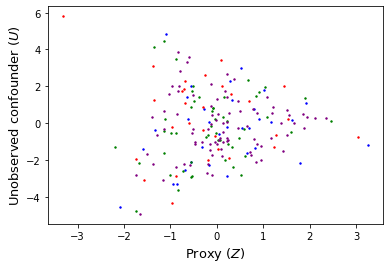

In [25]:
nb_dots = 200

color_chart = ['blue', 'red', 'green', 'purple']

data = np.concatenate((test_set['oracle'][:nb_dots, :], test_set['proxy'][:nb_dots, :], label[:nb_dots, :]), axis=1)

ens = pd.DataFrame(data)
ens.columns = ['oracle', 'proxy', 'label']

for k in np.arange(4):
    plt.scatter(ens[ens['label']==k+1]['proxy'], ens[ens['label']==k+1]['oracle'], color=color_chart[k],  s=2)

plt.ylabel('Unobserved confounder ($U$)', fontsize=13)
plt.xlabel('Proxy ($Z$)', fontsize=13)

Text(0.5, 0, 'Proxy ($Z$)')

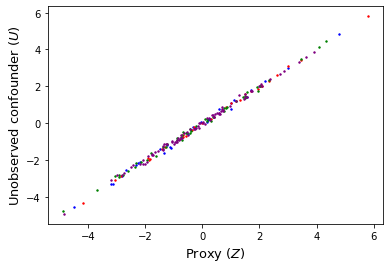

In [26]:
nb_dots = 1000

color_chart = ['blue', 'red', 'green', 'purple']

data = np.concatenate((test_set['oracle'][:nb_dots, :], test_set['random'][:nb_dots, :], label[:nb_dots, :]), axis=1)

ens = pd.DataFrame(data)
ens.columns = ['oracle', 'proxy', 'label']

for k in np.arange(4):
    plt.scatter(ens[ens['label']==k+1]['proxy'], ens[ens['label']==k+1]['oracle'], color=color_chart[k],  s=2)

plt.ylabel('Unobserved confounder ($U$)', fontsize=13)
plt.xlabel('Proxy ($Z$)', fontsize=13)